# Introduction

This project serves as an attempt to predict a Major League Baseball player's position given thier hitting data. I'm building off of a similar project that soley focused on supervised techniques. In this approach, we'll apply some unsupervised techniques as well to see if they provide better performance

The data being used is from [MLB Hittand and Pitching stats through the years](https://www.kaggle.com/datasets/joyshil0599/mlb-hitting-and-pitching-stats-through-the-years/data) compiled by kaggle user Joy Shil (and likely scraped from [Baseball Reference](https://www.baseball-reference.com/))

## About the MLB

If you're unfamiliar with Baseball or the MLB: there are 9 different defensive positions that a player could occupy. They are typically grouped into the Outfield (Right Fielders, Center Fielders, and Left Fielders) and the Infield (1st Basemen, 2nd Basemen, 3rd Basemen, Shortstops, and Catchers). Pitchers are being excluded from this as historically (since 1973) only the National League required them to hit and starting in 2022, neither league required pitchers to hit. Designated Hitters (the replacement for pitchers in the offensive lineup) are also excluded due to a lack of historical data, and the fact that they aren't a defensive position.

## Motivation for the project

Within Major League Baseball, there is a general consensus that certain positions should be better hitters than others. The defensive effort to play positions like Shortstop or 2nd Base is much greater than that of the Outfield or 1st Base. Therefore, to be an 'effective' Outfielder, players are expected to be much better hitters. I want to explore if we can see any evidence of that in the historical hitting data.

## General approach and TL;DR

Unfortunately, our attempts at applying unsupervised techniques to this data ended up performing very poorly. There's several reasons why this might be the case, but I'm hesitant to say that the data just doesn't have predictive power for this application. We saw decent performance in the previous iteration of this project that only used supervised methods. If I had to guess, the real problem is our preprocessing of the data. Clustering methods are very sensitive to outlier data. I tried to mitigate this by normalizing our data, but there may be other transformations that would prove useful on another attempt.

Since most of the fields provided were 'counting' stats, they were hugely influenced by the number of games a player participated in and how long their career was. To remedy this, I converted most fields to a 'rate' metric by dividing fields like Homeruns, Doubles, etc by the number of At-Bats a player had. The OPS column was dropped since it is just the addition of two other field. In addition, Walks were not converted into a rate metric and were instead dropped due to some nuance around how they affect At-Bats. Steals and Caught stealing were similarly dropped since they are not hitting metrics.

In [1]:
import itertools
import math
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", "use_inf_as_na")

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mlb-hitting-and-pitching-stats-through-the-years/baseball_pitcher.csv
/kaggle/input/mlb-hitting-and-pitching-stats-through-the-years/baseball_hitting.csv


# Data Inspection and Cleaning

In [2]:
data_raw = pd.read_csv('/kaggle/input/mlb-hitting-and-pitching-stats-through-the-years/baseball_hitting.csv')
data_raw.head()

,Player name,position,Games,At-bat,Runs,Hits,Double (2B),third baseman,home run,run batted in,a walk,Strikeouts,stolen base,Caught stealing,AVG,On-base Percentage,Slugging Percentage,On-base Plus Slugging
0,B Bonds,LF,2986.0,9847.0,2227.0,2935.0,601.0,77.0,762.0,1996.0,2558.0,1539,514.0,141,0.298,0.444,0.607,1.051
1,H Aaron,RF,3298.0,12364.0,2174.0,3771.0,624.0,98.0,755.0,2297.0,1402.0,1383,240.0,73,0.305,0.374,0.555,0.929
2,B Ruth,RF,2504.0,8399.0,2174.0,2873.0,506.0,136.0,714.0,2213.0,2062.0,1330,123.0,117,0.342,0.474,0.690,1.164
3,A Pujols,1B,3080.0,11421.0,1914.0,3384.0,686.0,16.0,703.0,2218.0,1373.0,1404,117.0,43,0.296,0.374,0.544,0.918
4,A Rodriguez,SS,2784.0,10566.0,2021.0,3115.0,548.0,31.0,696.0,2086.0,1338.0,2287,329.0,76,0.295,0.380,0.550,0.930


In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2508 entries, 0 to 2507
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Player name            2500 non-null   object 
 1   position               2500 non-null   object 
 2   Games                  2500 non-null   float64
 3   At-bat                 2500 non-null   float64
 4   Runs                   2500 non-null   float64
 5   Hits                   2500 non-null   float64
 6   Double (2B)            2500 non-null   float64
 7   third baseman          2500 non-null   float64
 8   home run               2500 non-null   float64
 9   run batted in          2500 non-null   float64
 10  a walk                 2500 non-null   float64
 11  Strikeouts             2500 non-null   object 
 12  stolen base            2500 non-null   float64
 13  Caught stealing        2500 non-null   object 
 14  AVG                    2500 non-null   float64
 15  On-b

In [4]:
data_raw.describe()

,Games,At-bat,Runs,Hits,Double (2B),third baseman,home run,run batted in,a walk,stolen base,AVG,On-base Percentage,Slugging Percentage,On-base Plus Slugging
count,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.0000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2488.000000
mean,1084.558000,3714.962000,521.644800,1010.86560,181.858000,32.3308,100.611600,494.206400,373.038000,76.09520,0.263320,0.331582,0.409925,0.741695
std,595.403651,2290.458916,380.061349,681.62211,124.474271,35.6680,99.984933,362.625548,297.480896,113.94476,0.024778,0.030770,0.050081,0.071959
min,2.000000,262.000000,32.000000,57.00000,7.000000,0.0000,17.000000,37.000000,19.000000,0.00000,0.123000,0.157000,0.197000,0.354000
25%,616.750000,1874.500000,231.750000,471.25000,86.000000,9.0000,33.000000,222.000000,162.000000,11.00000,0.247000,0.311000,0.375000,0.693000
50%,998.000000,3266.500000,423.500000,853.50000,154.000000,20.0000,69.000000,404.000000,292.500000,32.00000,0.262000,0.330000,0.407000,0.738000
75%,1438.250000,5105.750000,719.250000,1399.25000,249.000000,42.2500,125.500000,656.250000,486.250000,89.00000,0.278000,0.351000,0.441000,0.784000
max,3562.000000,14053.000000,2295.000000,4256.00000,792.000000,309.0000,762.000000,2297.000000,2558.000000,1406.00000,0.367000,0.482000,0.690000,1.164000


### Just like before, we're going to have to do some cleaning.
### We'll need to clean up column names/datatypes, derive a few new features and adjust our counting stats to be rate-based.

In [5]:
def compute_singles(row):
    return row['hits'] - row['doubles'] - row['triples'] - row['hr']


def compute_rate(row, column_name):
    return row[column_name]/row['ab']

In [6]:
data_clean = data_raw.drop('Player name', axis=1) # Drop Player Name column

data_clean = data_clean.rename(columns={'Games':'games', 'At-bat': 'ab', 'Runs': 'runs', 'Hits': 'hits',\
                          'Double (2B)': 'doubles', 'third baseman': 'triples', 'home run': 'hr',\
                          'run batted in': 'rbi', 'a walk': 'walks', 'Strikeouts': 'strikeouts', \
                          'stolen base ': 'steals', 'Caught stealing': 'caught', 'AVG': 'avg', \
                          'On-base Percentage': 'obp', 'Slugging Percentage': 'slg', 'On-base Plus Slugging': 'ops'}) # Rename columns to be easier to work with

data_clean[data_clean['caught'] == '--'] = 0 # Fix data types
data_clean[data_clean['strikeouts'] == '--'] = 0
data_clean.strikeouts = pd.to_numeric(data_clean.strikeouts)
data_clean.caught = pd.to_numeric(data_clean.caught)

data_clean = data_clean.dropna() # Drop any nulls
data_clean = data_clean.drop(data_clean[data_clean['games'] == 0].index) # Drop players with 0 games/stats

data_clean['singles'] = data_clean.apply(compute_singles, axis=1) # Impute a column for singles
data_clean['run_rate'] = data_clean.apply(compute_rate, axis=1, column_name='runs')
data_clean['single_rate'] = data_clean.apply(compute_rate, axis=1, column_name='singles')
data_clean['double_rate'] = data_clean.apply(compute_rate, axis=1, column_name='doubles')
data_clean['triple_rate'] = data_clean.apply(compute_rate, axis=1, column_name='triples')
data_clean['hr_rate'] = data_clean.apply(compute_rate, axis=1, column_name='hr')
data_clean['rbi_rate'] = data_clean.apply(compute_rate, axis=1, column_name='rbi')
data_clean['so_rate'] = data_clean.apply(compute_rate, axis=1, column_name='strikeouts')

positions = data_clean['position']
data_clean = data_clean[['run_rate', 'single_rate', 'double_rate', 'triple_rate', 'hr_rate', 'rbi_rate', 'so_rate', 'avg', 'obp', 'slg', 'ops']]
normalized_df=(data_clean-data_clean.mean())/data_clean.std()
data_clean = normalized_df

data_clean['position'] = positions
data_clean.head()

,run_rate,single_rate,double_rate,triple_rate,hr_rate,rbi_rate,so_rate,avg,obp,slg,ops,position
0,4.173437,-0.979169,1.465780,0.168988,3.307218,2.602490,-0.269131,1.501254,3.770678,3.895553,4.304609,LF
1,1.945507,0.309184,0.256146,0.191953,2.190835,2.002497,-0.859838,1.791127,1.447058,2.861098,2.607334,RF
2,5.620149,0.121107,1.375493,1.972738,3.828904,4.757867,-0.241733,3.323313,4.766516,5.546701,5.876674,RF
3,1.580420,-0.159349,1.354830,-1.213799,2.224279,2.301158,-0.712615,1.418433,1.447058,2.642272,2.454301,1B
4,2.629056,-0.126251,0.415912,-0.883541,2.519689,2.415413,0.530602,1.377023,1.646225,2.761632,2.621246,SS


# EDA and Visualizations

### Next, we'll add our positional categories and do some visualizations

In [7]:
def binary_position(position):
    if position in ['1B', '2B', '3B', 'SS', 'C']:
        return 'INF'
    else:
        return 'OF'

binary_hitters = data_clean.loc[(data_clean.position != 'P') & (data_clean.position != 'DH')]
data_clean = data_clean.drop(data_clean[data_clean['position'] == 'P'].index)
data_clean = data_clean.drop(data_clean[data_clean['position'] == 'DH'].index)
data_clean = data_clean.drop(data_clean[data_clean['position'] == 'OF'].index)

binary_hitters['bin_pos'] = binary_hitters['position'].apply(binary_position)
binary_hitters = binary_hitters.drop(columns=['position'])

/tmp/ipykernel_17/2450981952.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_hitters['bin_pos'] = binary_hitters['position'].apply(binary_position)


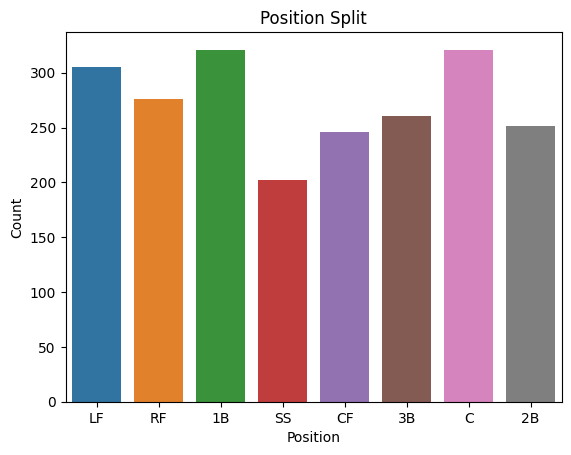

In [8]:
sns.countplot(data=data_clean, x='position')
plt.title('Position Split')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

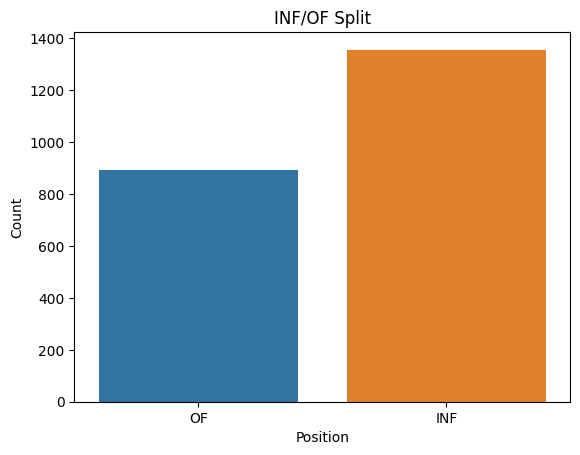

In [9]:
sns.countplot(data=binary_hitters, x='bin_pos')
plt.title('INF/OF Split')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

In [10]:
X = binary_hitters.drop(['bin_pos'], axis=1)
y = binary_hitters.bin_pos

y = LabelEncoder().fit_transform(y) #OF = 1, INF = 0
bin_pos_to_label = {
    0: 'OF',
    1: 'INF'
}
bin_label_to_position = {
    'OF': 0,
    'INF': 1
}

multi_label_to_pos = { # Derived by using the Inverse Transform from the LabelEncoder
    0: '1B',
    1: '2B',
    2: '3B',
    3: 'C',
    4: 'CF',
    5: 'LF',
    6: 'RF', 
    7: 'SS'
}
multi_position_to_label = {
    '1B': 0,
    '2B': 1,
    '3B': 2,
    'C': 3,
    'CF': 4,
    'LF': 5,
    'RF': 6,
    'SS': 7
}

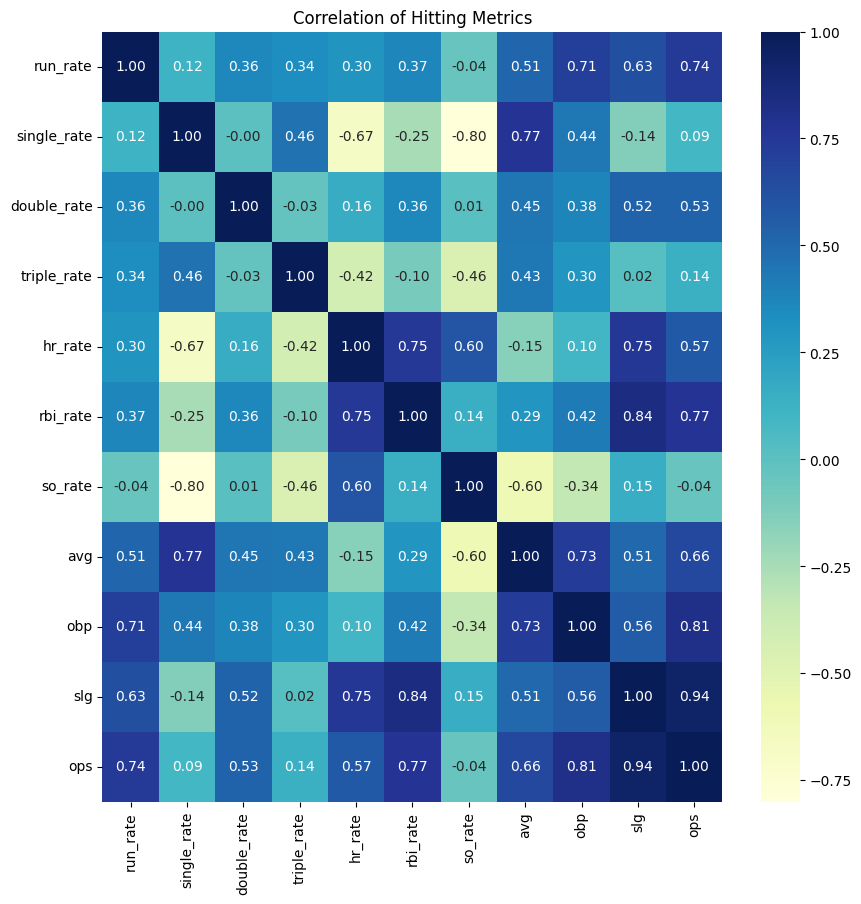

In [11]:
correlation = X.corr()

plt.figure(figsize=(10,10))
sns.heatmap(data=correlation, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Correlation of Hitting Metrics')
plt.show()

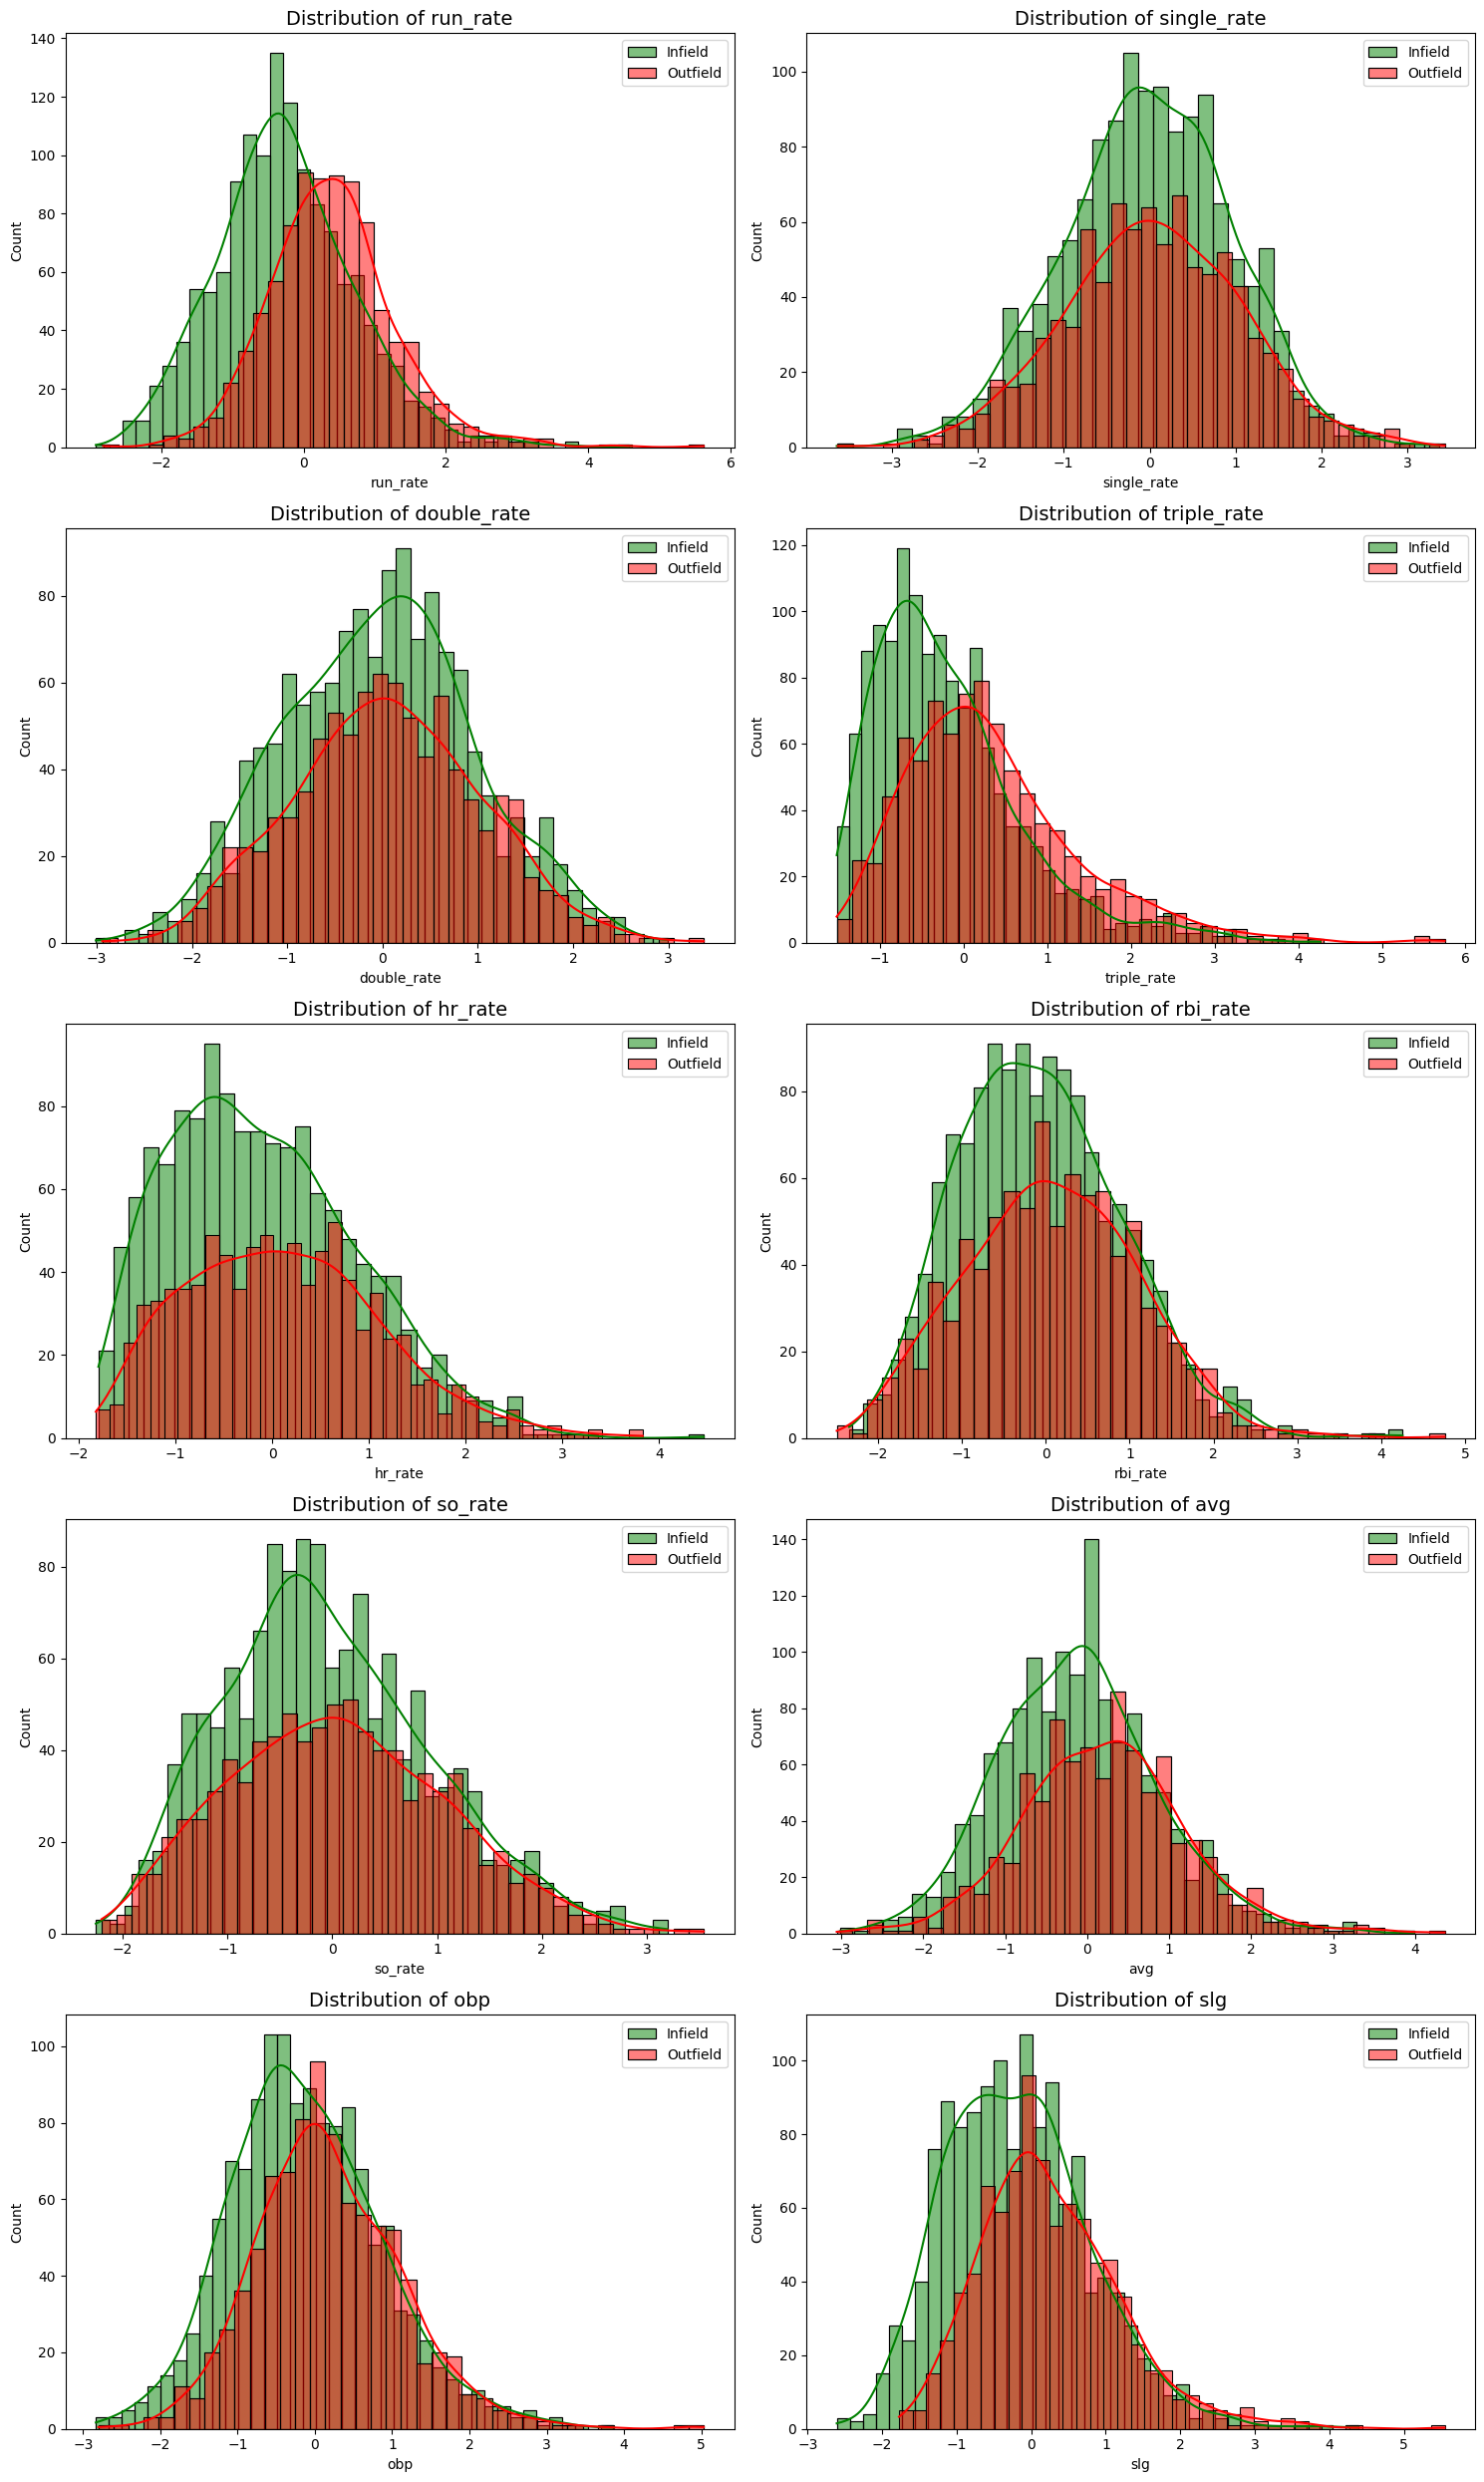

In [12]:
hitting_metrics = ['run_rate', 'single_rate', 'double_rate', 'triple_rate', 'hr_rate', 'rbi_rate', 'so_rate', 'avg', 'obp', 'slg']

infielders = binary_hitters[binary_hitters.bin_pos == 'INF']
outfielders = binary_hitters[binary_hitters.bin_pos == 'OF']

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for ax, metric in zip(axes.ravel(), hitting_metrics):
    sns.histplot(infielders[metric], bins=40, label='Infield', kde=True, color='green', ax=ax, alpha=0.5)
    sns.histplot(outfielders[metric], bins=40, label='Outfield', kde=True, color='red', ax=ax, alpha=0.5)
    
    ax.set_title(f'Distribution of {metric}', fontsize=14)
    ax.legend()

plt.tight_layout()
plt.show()

### We can see from the histograms that there isn't a ton of difference in the distributions of the hitting metrics. However, the distributions mean is slightly higher for Outfielders for most metrics. This lends some credence to the idea that Outfielders need to be better hitters to make up for the easier defensive workload

# Binary Classification

In [13]:
X = X.drop(columns=['ops'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1883) #The year the Phillies were founded :) 
X_train_resample, y_train_resample = SMOTE(random_state=1883).fit_resample(X_train, y_train)
print(f'Imbalanced class sampling: {Counter(y_train)}')
print(f'Balanced class sampling: {Counter(y_train_resample)}')

Imbalanced class sampling: Counter({0: 944, 1: 631})
Balanced class sampling: Counter({0: 944, 1: 944})


In [14]:
def print_metrics(y_pred, y_true, multiclass=False, multimap=None):
    if multiclass:
        pred_map = multimap
        label_map = multi_label_to_pos
    else:
        pred_map = bin_pos_to_label
        label_map = bin_pos_to_label
        
    y_true_pos = [label_map[pos] for pos in y_true]
    y_pred_pos = [pred_map[pos] for pos in y_pred]

    matrix = confusion_matrix(y_true_pos, y_pred_pos, labels=list(label_map.values()))

    cmd = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(label_map.values()))

    cmd.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    report = classification_report(y_true_pos, y_pred_pos, target_names=list(label_map.values()))
    print(report)

## KMeans Clusters

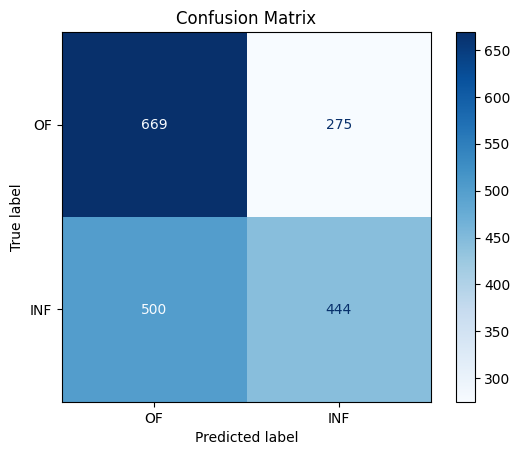

              precision    recall  f1-score   support

          OF       0.62      0.47      0.53       944
         INF       0.57      0.71      0.63       944

    accuracy                           0.59      1888
   macro avg       0.59      0.59      0.58      1888
weighted avg       0.59      0.59      0.58      1888



In [15]:
kmeans = KMeans(n_clusters=2, random_state=1883, n_init='auto')
y_pred_kmeans = kmeans.fit_predict(X_train_resample)
print_metrics(y_pred_kmeans, y_train_resample, multiclass=False)

### Let's see if we can get better performance out of this by using GridSearch for hyperparameter tuning

In [16]:
paramgrid = {
    'init': ['random', 'k-means++'],
    'n_init': ['auto', 10, 50, 100],
    'max_iter': [300, 500, 750, 1000],
    'algorithm': ['lloyd', 'elkan']
}
kmeans = KMeans(n_clusters=2, random_state=1883)
kmeans_grid = GridSearchCV(estimator=kmeans, param_grid=paramgrid, n_jobs=-1)
kmeans_grid.fit(X_train, y_train)

best_kmeans_model = kmeans_grid.best_estimator_
best_kmeans_params = kmeans_grid.best_params_

print("Params for our Best Model:")
print(best_kmeans_params)

Params for our Best Model:
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_init': 'auto'}


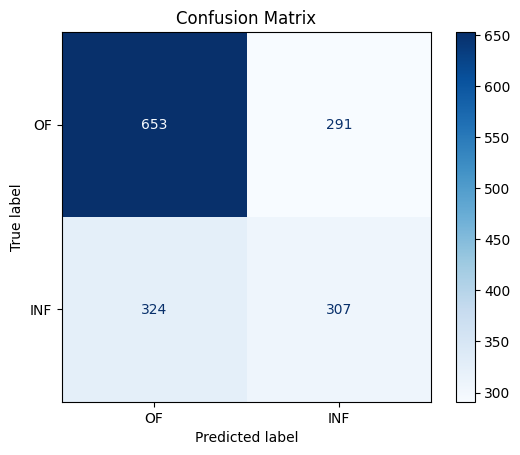

              precision    recall  f1-score   support

          OF       0.51      0.49      0.50       631
         INF       0.67      0.69      0.68       944

    accuracy                           0.61      1575
   macro avg       0.59      0.59      0.59      1575
weighted avg       0.61      0.61      0.61      1575



In [17]:
y_pred_tuned = best_kmeans_model.fit_predict(X_train)
print_metrics(y_pred_tuned, y_train, multiclass=False)

## Hierarchical Clustering

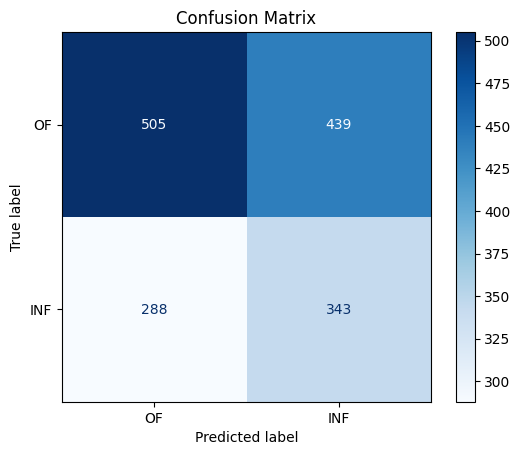

              precision    recall  f1-score   support

          OF       0.44      0.54      0.49       631
         INF       0.64      0.53      0.58       944

    accuracy                           0.54      1575
   macro avg       0.54      0.54      0.53      1575
weighted avg       0.56      0.54      0.54      1575



In [18]:
hcluster = AgglomerativeClustering(n_clusters=2)
y_pred_hc = hcluster.fit_predict(X_train)
print_metrics(y_pred_hc, y_train)

In [19]:
def accuracy_measure(hc, X_train, y):
    y_pred = hc.fit_predict(X_train)
    
    return accuracy_score(y, y_pred)

paramgrid_hc = {
    'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
    'linkage': ['complete', 'average', 'single']
}
hc_model = AgglomerativeClustering(n_clusters=2)
hc_grid = GridSearchCV(estimator=hc_model, scoring=accuracy_measure, param_grid=paramgrid_hc, n_jobs=-1)
hc_grid.fit(X_train, y_train)

best_hc_model = hc_grid.best_estimator_
best_hc_params = hc_grid.best_params_

print("Params for our best model: ")
print(best_hc_params)

Params for our best model: 
{'linkage': 'average', 'metric': 'l1'}


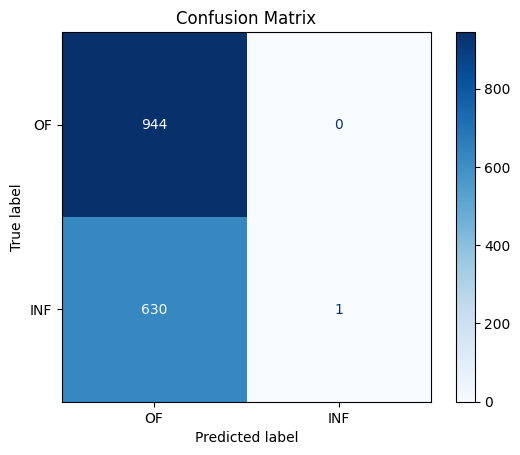

              precision    recall  f1-score   support

          OF       1.00      0.00      0.00       631
         INF       0.60      1.00      0.75       944

    accuracy                           0.60      1575
   macro avg       0.80      0.50      0.38      1575
weighted avg       0.76      0.60      0.45      1575



In [20]:
y_pred_tuned = best_hc_model.fit_predict(X_train)
print_metrics(y_pred_tuned, y_train, multiclass=False)

## Supervised Methods

In [21]:
trees = np.linspace(50, 500, 10, endpoint=True, dtype=int)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
parameters = {'n_estimators': trees, 'learning_rate': learning_rate}

base = AdaBoostClassifier(random_state=1883)
ada_grid = GridSearchCV(estimator=base, param_grid=parameters, n_jobs=-1, cv=5)
ada_grid.fit(X_train, y_train)

best_ada_estimator = ada_grid.best_estimator_
best_ada_params = ada_grid.best_params_

print("Best Parameters for our Model: ")
print(best_ada_params)

Best Parameters for our Model: 
{'learning_rate': 0.1, 'n_estimators': 200}


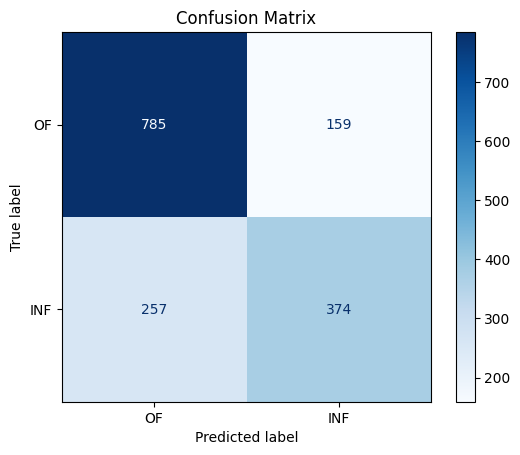

              precision    recall  f1-score   support

          OF       0.70      0.59      0.64       631
         INF       0.75      0.83      0.79       944

    accuracy                           0.74      1575
   macro avg       0.73      0.71      0.72      1575
weighted avg       0.73      0.74      0.73      1575



In [22]:
y_pred_ada = best_ada_estimator.predict(X_train)

print_metrics(y_pred_ada, y_train, multiclass=False)

# Multi-Class Approaches

In [23]:
multi_pos = data_clean.drop(columns=['ops'])
X_multi = multi_pos.drop(columns=['position'])
y_multi = multi_pos.position

multi_encoder = LabelEncoder()
multi_encoder.fit(y_multi)
y_multi = multi_encoder.transform(y_multi)

In [24]:
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_multi, y_multi, test_size=.3, random_state=1883)
X_m_resample, y_m_resample = SMOTE(random_state=1883).fit_resample(X_m_train, y_m_train)
print(f'Imbalanced class sampling: {Counter(y_m_train)}')
print(f'Balanced class sampling: {Counter(y_m_resample)}')

Imbalanced class sampling: Counter({3: 228, 5: 215, 0: 210, 6: 196, 2: 183, 4: 180, 1: 173, 7: 143})
Balanced class sampling: Counter({7: 228, 1: 228, 6: 228, 5: 228, 2: 228, 0: 228, 3: 228, 4: 228})


In [25]:

def find_mapping(y_pred, y_train):
    max_acc, mapping = 0, None
    for p in itertools.permutations(range(8)):
        y_temp_transformed = [p[idx] for idx in y_pred]
        acc = accuracy_score(y_train, y_temp_transformed)
        if (acc > max_acc):
            max_acc = acc
            y_pred = y_temp_transformed
            mapping = p
    print("Max accuracy was: " + str(max_acc))
    position_map = { k: v for k,v in zip(mapping, multi_label_to_pos.values())}
    return position_map

## Clustering Methods

### We'll just dive right into GridSearch for our best models here

Params for our Best Model:
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_init': 100}
Max accuracy was: 0.2205497382198953


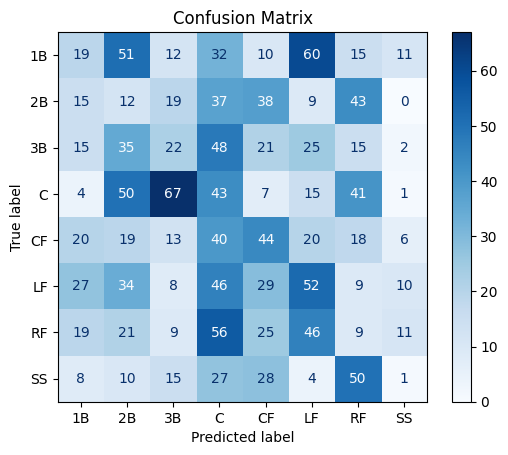

              precision    recall  f1-score   support

          1B       0.15      0.09      0.11       210
          2B       0.05      0.07      0.06       173
          3B       0.13      0.12      0.13       183
           C       0.13      0.19      0.15       228
          CF       0.22      0.24      0.23       180
          LF       0.23      0.24      0.23       215
          RF       0.04      0.05      0.05       196
          SS       0.02      0.01      0.01       143

    accuracy                           0.13      1528
   macro avg       0.12      0.13      0.12      1528
weighted avg       0.13      0.13      0.13      1528



In [26]:
paramgrid = {
    'init': ['random', 'k-means++'],
    'n_init': ['auto', 10, 50, 100],
    'max_iter': [300, 500, 750, 1000],
    'algorithm': ['lloyd', 'elkan']
}
kmeans_multi = KMeans(n_clusters=8, random_state=1883)
kmeans_multi_grid = GridSearchCV(estimator=kmeans_multi, param_grid=paramgrid, n_jobs=-1)
kmeans_multi_grid.fit(X_m_train, y_m_train)

best_kmeans_multi_model = kmeans_multi_grid.best_estimator_
best_kmeans_multi_params = kmeans_multi_grid.best_params_

print("Params for our Best Model:")
print(best_kmeans_multi_params)

y_pred_k_multi = best_kmeans_multi_model.fit_predict(X_m_train)
multi_pos_map = find_mapping(y_pred_k_multi, y_m_train)
print_metrics(y_pred_k_multi, y_m_train, multiclass=True, multimap=multi_pos_map)

Params for our best model: 
{'linkage': 'single', 'metric': 'cosine'}
Max accuracy was: 0.1511780104712042


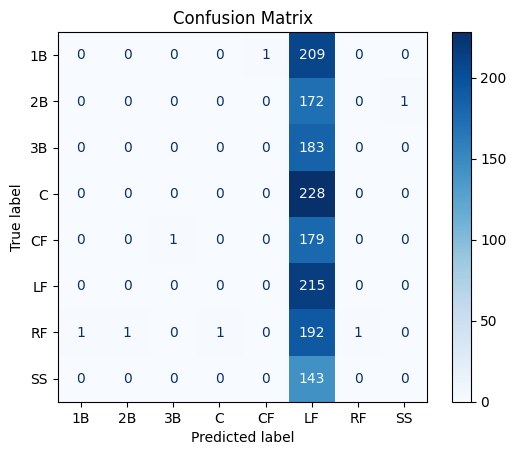

              precision    recall  f1-score   support

          1B       0.00      0.00      0.00       210
          2B       0.00      0.00      0.00       173
          3B       0.00      0.00      0.00       183
           C       0.00      0.00      0.00       228
          CF       0.00      0.00      0.00       180
          LF       0.14      1.00      0.25       215
          RF       1.00      0.01      0.01       196
          SS       0.00      0.00      0.00       143

    accuracy                           0.14      1528
   macro avg       0.14      0.13      0.03      1528
weighted avg       0.15      0.14      0.04      1528



In [27]:
def accuracy_measure(hc, X_train, y):
    y_pred = hc.fit_predict(X_train)
    
    return accuracy_score(y, y_pred)

paramgrid_hc = {
    'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
    'linkage': ['complete', 'average', 'single']
}
hc_model_multi = AgglomerativeClustering(n_clusters=8)
hc_grid_multi = GridSearchCV(estimator=hc_model_multi, scoring=accuracy_measure, param_grid=paramgrid_hc, n_jobs=-1)
hc_grid_multi.fit(X_train, y_train)

best_hc_model_multi = hc_grid_multi.best_estimator_
best_hc_multi_params = hc_grid_multi.best_params_

print("Params for our best model: ")
print(best_hc_multi_params)

y_pred_hc_multi = best_hc_model_multi.fit_predict(X_m_train)
multi_pos_map = find_mapping(y_pred_hc_multi, y_m_train)
print_metrics(y_pred_hc_multi, y_m_train, multiclass=True, multimap=multi_pos_map)

## Supervised Models

Best Parameters for our Model: 
{'learning_rate': 0.01, 'n_estimators': 400}


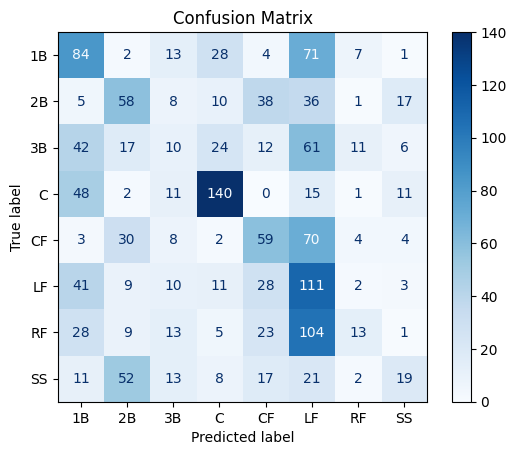

              precision    recall  f1-score   support

          1B       0.32      0.40      0.36       210
          2B       0.32      0.34      0.33       173
          3B       0.12      0.05      0.07       183
           C       0.61      0.61      0.61       228
          CF       0.33      0.33      0.33       180
          LF       0.23      0.52      0.32       215
          RF       0.32      0.07      0.11       196
          SS       0.31      0.13      0.19       143

    accuracy                           0.32      1528
   macro avg       0.32      0.31      0.29      1528
weighted avg       0.33      0.32      0.30      1528



In [28]:
trees = np.linspace(50, 500, 10, endpoint=True, dtype=int)
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
parameters = {'n_estimators': trees, 'learning_rate': learning_rate}

base_multi = AdaBoostClassifier(random_state=1883)
ada_grid_multi = GridSearchCV(estimator=base_multi, param_grid=parameters, n_jobs=-1, cv=5)
ada_grid_multi.fit(X_m_train, y_m_train)

best_ada_multi_estimator = ada_grid_multi.best_estimator_
best_ada_multi_params = ada_grid_multi.best_params_

print("Best Parameters for our Model: ")
print(best_ada_multi_params)

y_pred_ada_multi = best_ada_multi_estimator.predict(X_m_train)
print_metrics(y_pred_ada_multi, y_m_train, multiclass=True, multimap=multi_label_to_pos)

# Comparisons and Conclusions

### We can deploy some 2-D projections to help shed some light on the poor performance of our clustering algorithms. We'll use TSNE -- sort of similar to PCA in that it helps project high-dimensional data into 2 or 3 dimensions, but TSNE uses a probabiltiy mapping to determine which points are "close" together in the projection

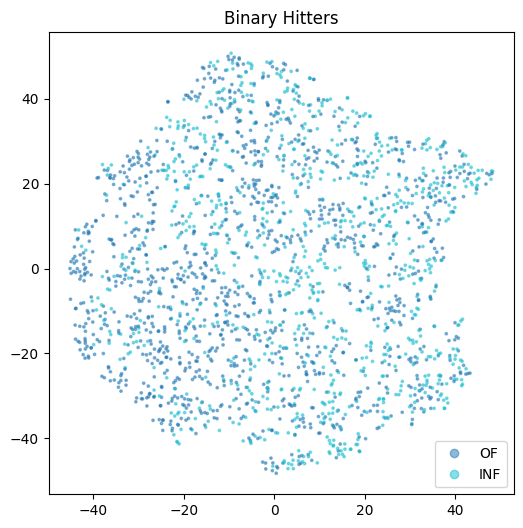

In [29]:
tsne = TSNE(n_components=2)
X_reduced = tsne.fit_transform(X)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                c=y, s=3, alpha=0.5, cmap="tab10");
ax.legend(handles=sc.legend_elements()[0], labels=bin_pos_to_label.values(), loc="lower right");
ax.set_title("Binary Hitters");

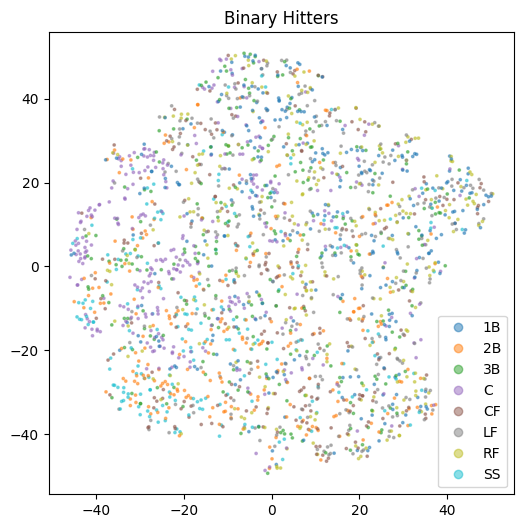

In [30]:
tsne = TSNE(n_components=2)
X_multi_reduced = tsne.fit_transform(X_multi)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc = ax.scatter(X_multi_reduced[:, 0], X_multi_reduced[:, 1], 
                c=y_multi, s=3, alpha=0.5, cmap="tab10");
ax.legend(handles=sc.legend_elements()[0], labels=multi_label_to_pos.values(), loc="lower right");
ax.set_title("Binary Hitters");

### The lack of any distinct clustering in this projection suggests that the data we have isn't well suited for this kind of task. A disappointing result but important nontheless! It could be that we need to explore better data pre-processing or even some other metrics beyond hitting data to help determine position.

### We'll do one final breakdown of the accuracies of all our models on the test set before we wrap up

In [31]:
# Binary Models
y_pred_kmeans = best_kmeans_model.fit_predict(X_test)
y_pred_hc = best_hc_model.fit_predict(X_test)
y_pred_ada = best_ada_estimator.predict(X_test)

kmeans_bin_score = accuracy_score(y_test, y_pred_kmeans)
hc_bin_score = accuracy_score(y_test, y_pred_hc)
ada_bin_score = accuracy_score(y_test, y_pred_ada)

# Multi-class Models
y_true_pos = [multi_label_to_pos[pos] for pos in y_m_test]

y_pred_multi_kmeans = best_kmeans_multi_model.fit_predict(X_m_test)
kmeans_mapping = find_mapping(y_pred_multi_kmeans, y_m_test)
y_pred_pos_kmeans = [kmeans_mapping[pos] for pos in y_pred_multi_kmeans]

y_pred_multi_hc = best_hc_model_multi.fit_predict(X_m_test)
hc_mapping = find_mapping(y_pred_multi_hc, y_m_test)
y_pred_pos_hc = [hc_mapping[pos] for pos in y_pred_multi_hc]

y_pred_multi_ada = best_ada_multi_estimator.predict(X_m_test)

kmeans_multi_score = accuracy_score(y_m_test, y_pred_multi_kmeans)
hc_multi_score = accuracy_score(y_m_test, y_pred_multi_hc)
ada_multi_score = accuracy_score(y_m_test, y_pred_multi_ada)

Max accuracy was: 0.2183206106870229
Max accuracy was: 0.17251908396946564


| Model | Accuracy Score |
| ----- | -------------- |
| Binary K-Means | 59.9 % |
| Binary Hierarchical Clustering | 61.3% |
| Binary Ada-Boosted Trees | 70.9% |
| Multi-Class K-Means | 16% |
| Multi-Class Hierarchical Clustering | 16.6% |
| Multi-Class Ada-Boosted Trees | 29.7% |